## Import Libraries

In [ ]:
import os
import cv2
import random
import pathlib

import numpy as np
import pandas as pd
import random as rn
import tensorflow as tf
import tensorflow_hub as hub

import plotly.subplots as sp
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from PIL import Image
from tensorflow import keras

from plotly.subplots import make_subplots
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG19, NASNetLarge, EfficientNetB7
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Num GPUs Available:  2


## Loading The Data

In [ ]:
meta_df = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Meta.csv')
train_df = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Test.csv')
test_df = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Train.csv')

In [ ]:
data_path = '/kaggle/input/gtsrb-german-traffic-sign'
train_data_path = os.path.join(data_path, 'Train')
test_data_path = os.path.join(data_path, 'Test')
meta_data_path = os.path.join(data_path, 'Meta')

height = 50
width = 50

In [ ]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons'
          }

In [ ]:
batch_size = 150
seed = 42

## Make Generator

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)
train_dataset = train_datagen.flow_from_directory(train_data_path,
                                                  target_size=(height, width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=seed,
                                                  color_mode='rgb',
                                                  interpolation='hamming',
                                                  subset='training')

test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.2)
test_dataset = test_datagen.flow_from_directory(train_data_path,
                                                target_size=(height, width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True,
                                                seed=seed,
                                                color_mode='rgb',
                                                interpolation='hamming',
                                                subset='validation')

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


## Plotting the original Traffic signs

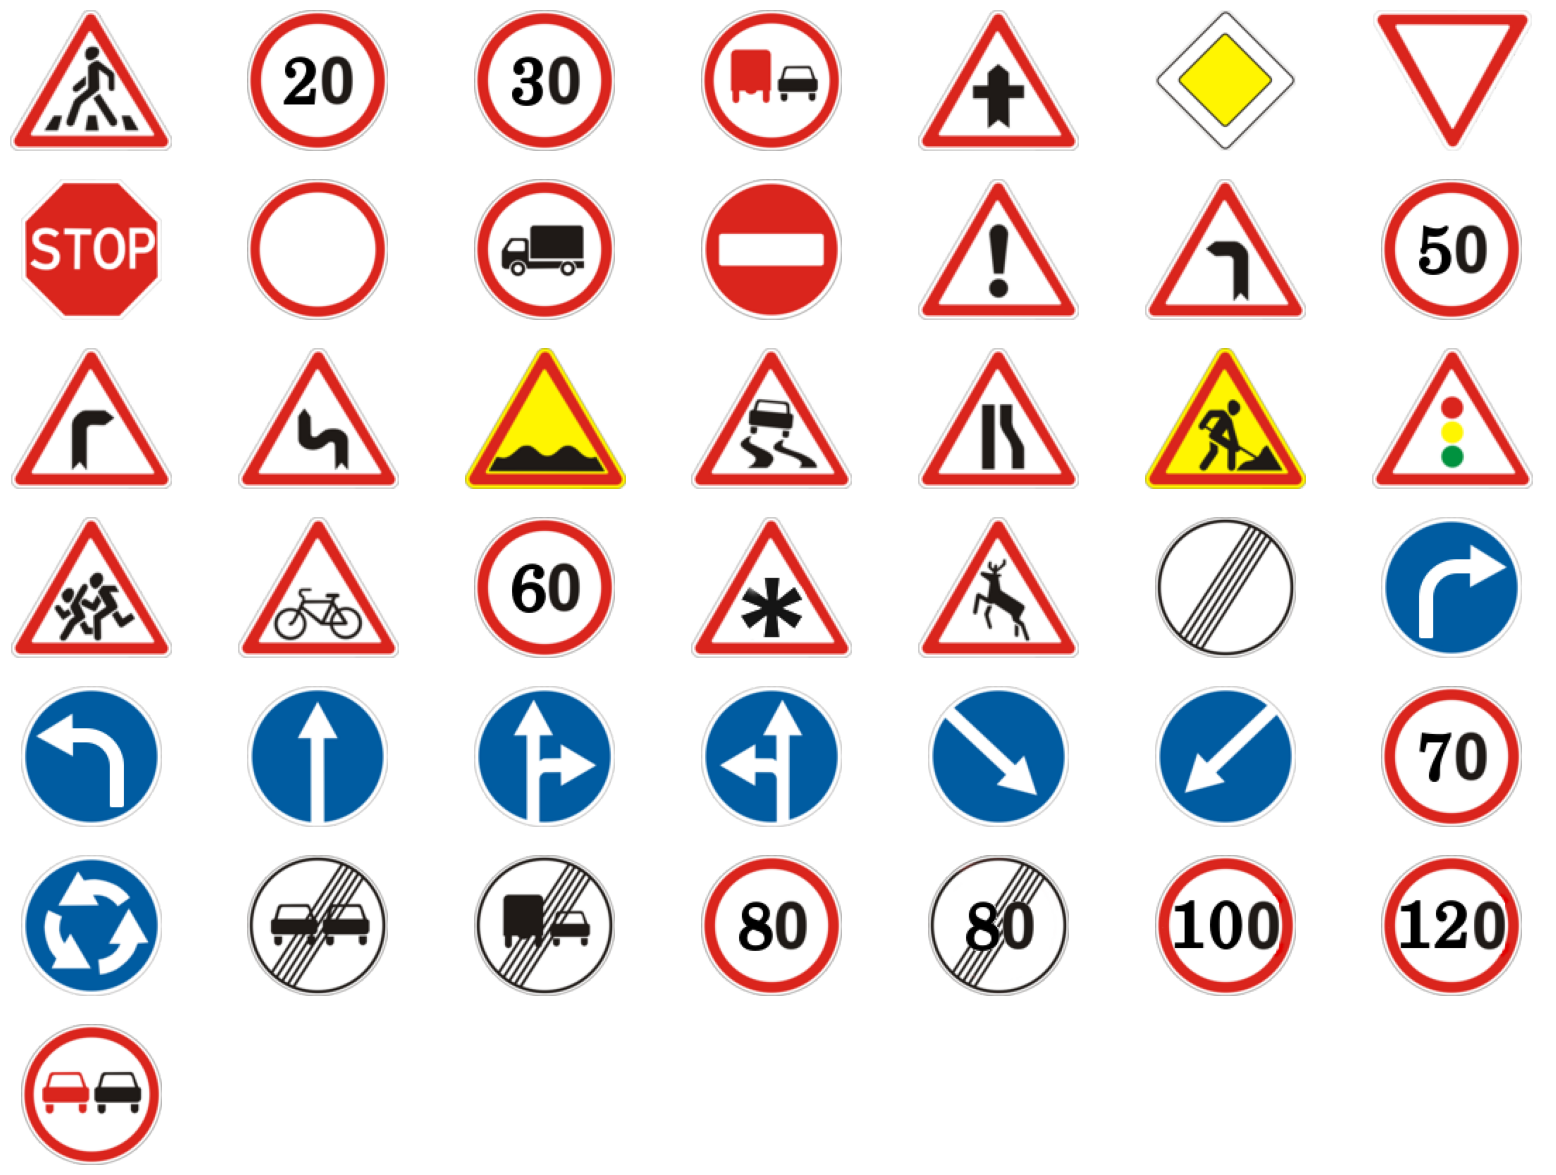

In [ ]:
num_pictures = 43
num_rows = (num_pictures - 1) // 7 + 1
num_cols = min(num_pictures, 7)

signs = [os.path.join(data_path, meta_df.Path.to_list()[i]) for i in range(num_pictures)]

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))
for i, image_path in enumerate(signs):
    image = Image.open(image_path)
    row = i // num_cols
    col = i % num_cols
    axes[row, col].imshow(image)
    axes[row, col].axis('off')

# Remove any remaining empty subplots
for i in range(num_pictures, num_rows * num_cols):
    axes.flat[i].axis('off')

plt.show()

## Plotting samples of the Traffic signs

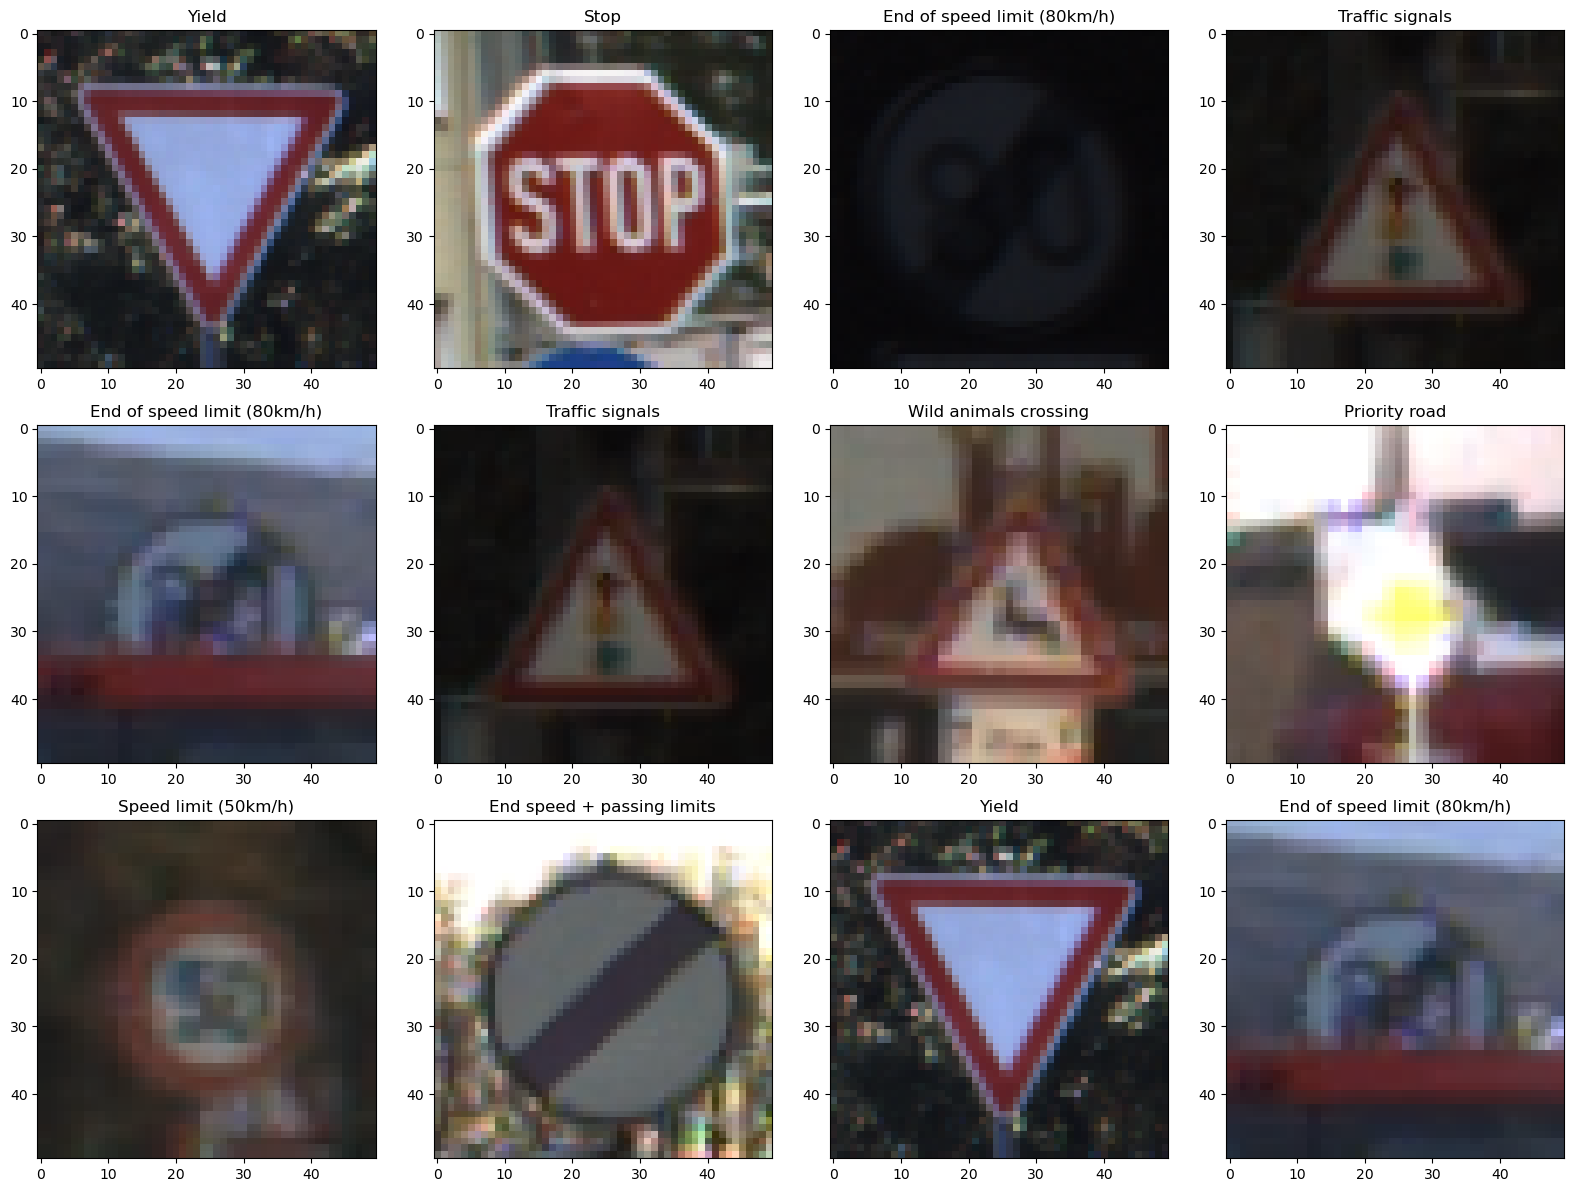

In [ ]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
img,y = train_dataset.next()
for i in range(3):
    for j in range (4):
        l=rn.randint(0,batch_size-1)
        label = classes[int(list(train_dataset.class_indices.keys())[np.argmax(y[l])])]
        ax[i,j].imshow(img[l])
        ax[i,j].set_title(label)

plt.tight_layout()

## The Distribution of the Class labels in the dataset

In [ ]:
# Assuming you have the train_df DataFrame with the data
classes = train_df["ClassId"].value_counts().head(43)

# Create a Plotly bar chart
fig = go.Figure()

fig.add_trace(go.Bar(
    x=classes.index,
    y=classes.values,
    marker_color='green'
))

fig.update_layout(
    title="Distribution of Class Labels in the dataset",
    xaxis_title="Classes",
    yaxis_title="Counts",
    xaxis=dict(type='category')
)

fig.show()

## Build CNN Model

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(5,5), activation='relu', input_shape=(height,width,3)),
    keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Dropout(rate=0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.25),

    keras.layers.Dense(43, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 16)        1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 32)        12832     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 21, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 21, 21, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 19, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 17, 17, 64)        3

## Compile CNN Model

In [ ]:
alpha=0.01
epochs=25
optim = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

## Fit CNN Model

In [ ]:
history = model.fit(train_dataset,
                    steps_per_epoch=len(train_dataset),
                    epochs=epochs,
                    validation_data=test_dataset,
                    validation_steps=len(test_dataset))

Epoch 1/25


2023-07-28 20:49:41.558497: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


210/210 [==============================] - 240s 1s/step - loss: 0.5705 - accuracy: 0.8485 - val_loss: 0.4171 - val_accuracy: 0.8936
Epoch 2/25
210/210 [==============================] - 48s 230ms/step - loss: 0.0760 - accuracy: 0.9765 - val_loss: 0.4505 - val_accuracy: 0.9032
Epoch 3/25
210/210 [==============================] - 44s 211ms/step - loss: 0.0535 - accuracy: 0.9834 - val_loss: 0.3647 - val_accuracy: 0.9379
Epoch 4/25
210/210 [==============================] - 44s 211ms/step - loss: 0.0288 - accuracy: 0.9911 - val_loss: 0.3473 - val_accuracy: 0.9195
Epoch 5/25
210/210 [==============================] - 44s 209ms/step - loss: 0.0408 - accuracy: 0.9873 - val_loss: 0.3772 - val_accuracy: 0.9301
Epoch 6/25
210/210 [==============================] - 44s 209ms/step - loss: 0.0282 - accuracy: 0.9914 - val_loss: 0.5001 - val_accuracy: 0.9110
Epoch 7/25
210/210 [==============================] - 44s 210ms/step - loss: 0.0350 - accuracy: 0.9901 - val_loss: 0.4253 - val_accuracy: 0.898

## Visualize the Learning of CNN Model

In [ ]:
# Create subplots with Plotly
fig = go.Figure()

# Plot Training and Validation Loss
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['loss'], mode='lines', name='Training Loss'))
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['val_loss'], mode='lines', name='Validation Loss'))

# Customize layout for Loss plot
fig.update_layout(
    title='Model Loss',
    xaxis_title='Epochs',
    yaxis_title='Loss',
    yaxis_range=[0, 1],
    legend=dict(x=0.7, y=1.1),
)

# Create another subplot for Accuracy
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['accuracy'], mode='lines', name='Training Accuracy'))
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['val_accuracy'], mode='lines', name='Validation Accuracy'))

# Customize layout for Accuracy plot
fig.update_layout(
    title='Model Accuracy',
    xaxis_title='Epochs',
    yaxis_title='Accuracy',
    yaxis_range=[0.5, 1],
)

# Adjust the subplot positioning and size
fig.update_layout(height=600, width=800, showlegend=True)

# Add a title for the entire figure
fig.update_layout(title_text='Custom CNN Performance')

# Show the figure
fig.show()

## Save CNN Model

In [ ]:
model.save("CNN.h5")

In [ ]:
data_dir = '/kaggle/input/gtsrb-german-traffic-sign/'

def map_pred(pred):
    return [int(list(train_dataset.class_indices.keys())[i]) for i in pred]

test_labels = test_df["ClassId"].values
imgs = test_df["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((height, width))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)

X_test = np.array(data)
X_test = X_test/255

## Predict accuracy of Model

In [ ]:
from sklearn.metrics import accuracy_score
pred = model.predict(X_test)
pred = map_pred(pred.argmax(axis=-1))

# Calculate the accuracy
test_accuracy = accuracy_score(test_labels, pred) * 100

# Print the test data accuracy with two digits after the decimal point and the percent symbol
print('Test Data accuracy: {:.2f}%'.format(test_accuracy))

1226/1226 [==============================] - 4s 3ms/step
Test Data accuracy: 96.39%


## Set Dictionary for Classes

In [ ]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons'
          }

5/5 [==============================] - 0s 45ms/step


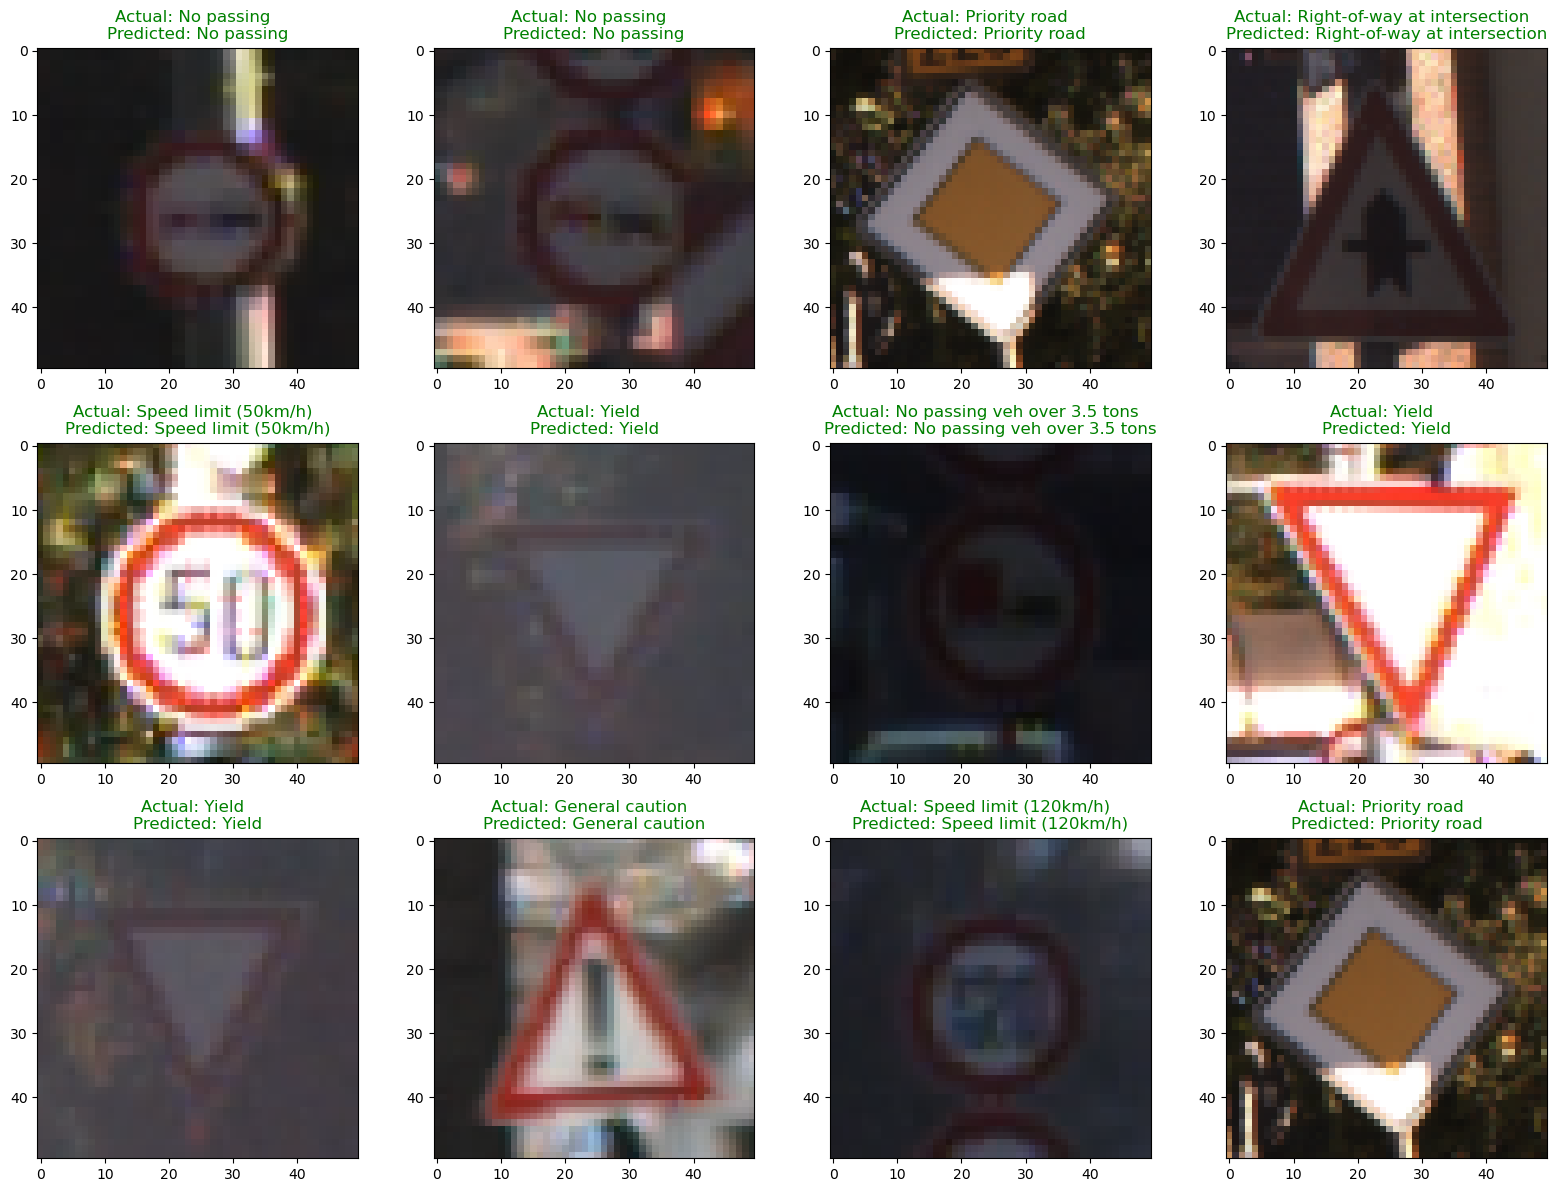

In [ ]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
val_images, val_labels = test_dataset.next()
predicted = model.predict(val_images)
predicts = map_pred(np.argmax(predicted, axis=-1))
labels = map_pred(np.argmax(val_labels, axis=-1))

for i in range(3):
    for j in range (4):
        idx=rn.randint(0,batch_size-1)
        ax[i,j].imshow(val_images[idx])
        if labels[idx] == predicts[idx]:
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'green')
        else:
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'red')

plt.tight_layout()

## Transfer Learning

### 1.VGG Model

In [ ]:
vgg_model = tf.keras.Sequential([VGG19(weights='imagenet', include_top=False, input_shape=(height,width,3)),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Flatten(),
                                 keras.layers.Dense(512, activation='sigmoid'),
                                 keras.layers.Dense(43, activation='softmax')
                                ])

vgg_model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 batch_normalization_3 (Batc  (None, 1, 1, 512)        2048      
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 43)                22059     
                                                                 
Total params: 20,311,147
Trainable params: 20,310,123
N

### 2.EfficientNetB7 Model

In [ ]:
# Load EfficientNetB7 model with pre-trained ImageNet weights
efficientnet_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(height, width, 3))

# Freeze the layers of the pre-trained model
efficientnet_model.trainable = True

# Create your custom model by adding additional layers
Efficientnet_Model = tf.keras.Sequential([
    efficientnet_model,
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='sigmoid'),
    keras.layers.Dense(43, activation='softmax')
])

Efficientnet_Model.summary()

258076736/258076736 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 2, 2, 2560)       64097687  
                                                                 
 batch_normalization_4 (Batc  (None, 2, 2, 2560)       10240     
 hNormalization)                                                 
                                                                 
 flatten_2 (Flatten)         (None, 10240)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               5243392   
                                                                 
 dense_5 (Dense)             (None, 43)                22059     
                                                                 
Total params: 69,373,378
Trainable params: 69,057,531

### 3.NASNetLarge Model

In [ ]:
# Load NASNetLarge model with pre-trained ImageNet weights
nasnet_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=(height, width, 3))

# Freeze the layers of the pre-trained model
nasnet_model.trainable = True

# Create your custom model by adding additional layers
Nasnet_Model = tf.keras.Sequential([
    nasnet_model,
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='sigmoid'),
    keras.layers.Dense(43, activation='softmax')
])

Nasnet_Model.summary()

343610240/343610240 [==============================] - 2s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 2, 2, 4032)        84916818  
                                                                 
 batch_normalization_5 (Batc  (None, 2, 2, 4032)       16128     
 hNormalization)                                                 
                                                                 
 flatten_3 (Flatten)         (None, 16128)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               8258048   
                                                                 
 dense_7 (Dense)             (None, 43)                22059     
                                                                 
Total params: 93,213,053
Trainable params: 93,008,321

## Compile Transfer Learning Models

In [ ]:
alpha = 0.001
epochs = 10

vgg_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=alpha), loss = 'categorical_crossentropy', metrics = ['accuracy'])
Efficientnet_Model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=alpha), loss = 'categorical_crossentropy', metrics=['accuracy'])
Nasnet_Model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=alpha), loss = 'categorical_crossentropy', metrics = ['accuracy'])

## Fit Transfer Learning Models

### 1. VGG Model

In [ ]:
vgg_history = vgg_model.fit(train_dataset,
                        steps_per_epoch=len(train_dataset),
                        epochs=epochs,
                        validation_data=test_dataset,
                        validation_steps=len(test_dataset))

Epoch 1/10
210/210 [==============================] - 61s 237ms/step - loss: 2.4678 - accuracy: 0.2789 - val_loss: 5.2958 - val_accuracy: 0.0617
Epoch 2/10
210/210 [==============================] - 49s 231ms/step - loss: 1.0016 - accuracy: 0.6964 - val_loss: 1.5711 - val_accuracy: 0.5309
Epoch 3/10
210/210 [==============================] - 49s 230ms/step - loss: 0.3623 - accuracy: 0.9030 - val_loss: 0.3754 - val_accuracy: 0.8893
Epoch 4/10
210/210 [==============================] - 48s 229ms/step - loss: 0.1568 - accuracy: 0.9625 - val_loss: 0.7386 - val_accuracy: 0.7665
Epoch 5/10
210/210 [==============================] - 50s 235ms/step - loss: 0.0819 - accuracy: 0.9809 - val_loss: 2.7723 - val_accuracy: 0.3882
Epoch 6/10
210/210 [==============================] - 48s 226ms/step - loss: 0.0647 - accuracy: 0.9837 - val_loss: 0.3588 - val_accuracy: 0.9017
Epoch 7/10
210/210 [==============================] - 48s 227ms/step - loss: 0.0382 - accuracy: 0.9914 - val_loss: 1.6273 - val_ac

### 2.EfficientNetB7 Model

In [ ]:
efficientnet_history = Efficientnet_Model.fit(train_dataset,
                        steps_per_epoch=len(train_dataset),
                        epochs=epochs,
                        validation_data=test_dataset,
                        validation_steps=len(test_dataset))

Epoch 1/10


2023-07-28 21:30:01.004953: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/efficientnetb7/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


210/210 [==============================] - 166s 622ms/step - loss: 0.4428 - accuracy: 0.8756 - val_loss: 5.2140 - val_accuracy: 0.0927
Epoch 2/10
210/210 [==============================] - 124s 590ms/step - loss: 0.0459 - accuracy: 0.9879 - val_loss: 4.0379 - val_accuracy: 0.2725
Epoch 3/10
210/210 [==============================] - 123s 586ms/step - loss: 0.0559 - accuracy: 0.9857 - val_loss: 10.4860 - val_accuracy: 0.0536
Epoch 4/10
210/210 [==============================] - 123s 585ms/step - loss: 0.0219 - accuracy: 0.9941 - val_loss: 12.7582 - val_accuracy: 0.0536
Epoch 5/10
210/210 [==============================] - 123s 585ms/step - loss: 0.0347 - accuracy: 0.9918 - val_loss: 4.7468 - val_accuracy: 0.0621
Epoch 6/10
210/210 [==============================] - 123s 585ms/step - loss: 0.0216 - accuracy: 0.9950 - val_loss: 2.1131 - val_accuracy: 0.4923
Epoch 7/10
210/210 [==============================] - 124s 588ms/step - loss: 0.0243 - accuracy: 0.9939 - val_loss: 2.4499 - val_accu

### 3.NASNetLarge Model

In [ ]:
nasnet_history = Nasnet_Model.fit(train_dataset,
                        steps_per_epoch=len(train_dataset),
                        epochs=epochs,
                        validation_data=test_dataset,
                        validation_steps=len(test_dataset))

Epoch 1/10
210/210 [==============================] - 320s 1s/step - loss: 0.5141 - accuracy: 0.8593 - val_loss: 3.7140 - val_accuracy: 0.2285
Epoch 2/10
210/210 [==============================] - 261s 1s/step - loss: 0.1313 - accuracy: 0.9706 - val_loss: 3.1189 - val_accuracy: 0.3677
Epoch 3/10
210/210 [==============================] - 261s 1s/step - loss: 0.0771 - accuracy: 0.9836 - val_loss: 3.2836 - val_accuracy: 0.1720
Epoch 4/10
210/210 [==============================] - 261s 1s/step - loss: 0.1087 - accuracy: 0.9757 - val_loss: 4.0750 - val_accuracy: 0.0107
Epoch 5/10
210/210 [==============================] - 261s 1s/step - loss: 0.0555 - accuracy: 0.9878 - val_loss: 4.9556 - val_accuracy: 0.0513
Epoch 6/10
210/210 [==============================] - 262s 1s/step - loss: 0.0610 - accuracy: 0.9871 - val_loss: 3.8261 - val_accuracy: 0.1251
Epoch 7/10
210/210 [==============================] - 261s 1s/step - loss: 0.0451 - accuracy: 0.9906 - val_loss: 3.4054 - val_accuracy: 0.2662

## Visualize the Learning of Transfer Learning Models

In [ ]:
# Create the DataFrame 'performance' for VGG19 model
vgg_performance = pd.DataFrame(vgg_history.history)

# Create the DataFrame 'performance' for EfficientNet model
efficientnet_performance = pd.DataFrame(efficientnet_history.history)

# Create the DataFrame 'performance' for NASNet model
nasnet_performance = pd.DataFrame(nasnet_history.history)

In [ ]:
# Create subplots with Plotly
fig = make_subplots(rows=1, cols=2, subplot_titles=("Model Accuracy", "Model Loss"))

# Plot Training and Validation Accuracy for VGG19 model
fig.add_trace(go.Scatter(x=vgg_performance.index, y=vgg_performance['accuracy'], mode='lines', name='VGG19 Training Accuracy'), row=1, col=1)
fig.add_trace(go.Scatter(x=vgg_performance.index, y=vgg_performance['val_accuracy'], mode='lines', name='VGG19 Validation Accuracy'), row=1, col=1)

# Plot Training and Validation Accuracy for EfficientNetB7 model
fig.add_trace(go.Scatter(x=efficientnet_performance.index, y=efficientnet_performance['accuracy'], mode='lines', name='EfficientNetB7 Training Accuracy'), row=1, col=1)
fig.add_trace(go.Scatter(x=efficientnet_performance.index, y=efficientnet_performance['val_accuracy'], mode='lines', name='EfficientNetB7 Validation Accuracy'), row=1, col=1)

# Plot Training and Validation Accuracy for NASNet model
fig.add_trace(go.Scatter(x=nasnet_performance.index, y=nasnet_performance['accuracy'], mode='lines', name='NASNet Training Accuracy'), row=1, col=1)
fig.add_trace(go.Scatter(x=nasnet_performance.index, y=nasnet_performance['val_accuracy'], mode='lines', name='NASNet Validation Accuracy'), row=1, col=1)

# Customize layout for Accuracy plot
fig.update_xaxes(title_text='Epochs', row=1, col=1)
fig.update_yaxes(title_text='Accuracy', range=[0, 1], row=1, col=1)

# Plot Training and Validation Loss for VGG19 model
fig.add_trace(go.Scatter(x=vgg_performance.index, y=vgg_performance['loss'], mode='lines', name='VGG19 Training Loss'), row=1, col=2)
fig.add_trace(go.Scatter(x=vgg_performance.index, y=vgg_performance['val_loss'], mode='lines', name='VGG19 Validation Loss'), row=1, col=2)

# Plot Training and Validation Loss for EfficientNetB7 model
fig.add_trace(go.Scatter(x=efficientnet_performance.index, y=efficientnet_performance['loss'], mode='lines', name='EfficientNetB7 Training Loss'), row=1, col=2)
fig.add_trace(go.Scatter(x=efficientnet_performance.index, y=efficientnet_performance['val_loss'], mode='lines', name='EfficientNetB7 Validation Loss'), row=1, col=2)

# Plot Training and Validation Loss for NASNet model
fig.add_trace(go.Scatter(x=nasnet_performance.index, y=nasnet_performance['loss'], mode='lines', name='NASNet Training Loss'), row=1, col=2)
fig.add_trace(go.Scatter(x=nasnet_performance.index, y=nasnet_performance['val_loss'], mode='lines', name='NASNet Validation Loss'), row=1, col=2)

# Customize layout for Loss plot
fig.update_xaxes(title_text='Epochs', row=1, col=2)
fig.update_yaxes(title_text='Loss', range=[0, 1], row=1, col=2)

# Adjust the subplot positioning and size
fig.update_layout(height=600, width=1000, title_text='Model Performance Comparison')

# Show the figure
fig.show()

## Predict Accuracy of Transfer Learning Models

In [ ]:
from sklearn.metrics import accuracy_score
# VGG19
vgg_pred = vgg_model.predict(X_test)
vgg_pred = map_pred(vgg_pred.argmax(axis=-1))

# Efficientnet
Efficientnet_pred = Efficientnet_Model.predict(X_test)
Efficientnet_pred = map_pred(Efficientnet_pred.argmax(axis=-1))

# Nasnet
Nasnet_pred = Nasnet_Model.predict(X_test)
Nasnet_pred = map_pred(Nasnet_pred.argmax(axis=-1))

# Calculate the accuracy
vgg_test_accuracy = accuracy_score(test_labels, vgg_pred) * 100
Efficientnet_test_accuracy = accuracy_score(test_labels, Efficientnet_pred) * 100
Nasnet_test_accuracy = accuracy_score(test_labels, Nasnet_pred) * 100

# Print the test data accuracy with two digits after the decimal point and the percent symbol
print('VGG Test Data accuracy: {:.2f}%'.format(vgg_test_accuracy))
print('Efficientnet Test Data accuracy: {:.2f}%'.format(Efficientnet_test_accuracy))
print('NASNetTest Data accuracy: {:.2f}%'.format(Nasnet_test_accuracy))

1226/1226 [==============================] - 60s 43ms/step
VGG Test Data accuracy: 18.16%
Efficientnet Test Data accuracy: 21.51%
NASNetTest Data accuracy: 6.22%


## Results of Prediction by Transfer Learning Models

### 1. VGG19

5/5 [==============================] - 1s 140ms/step


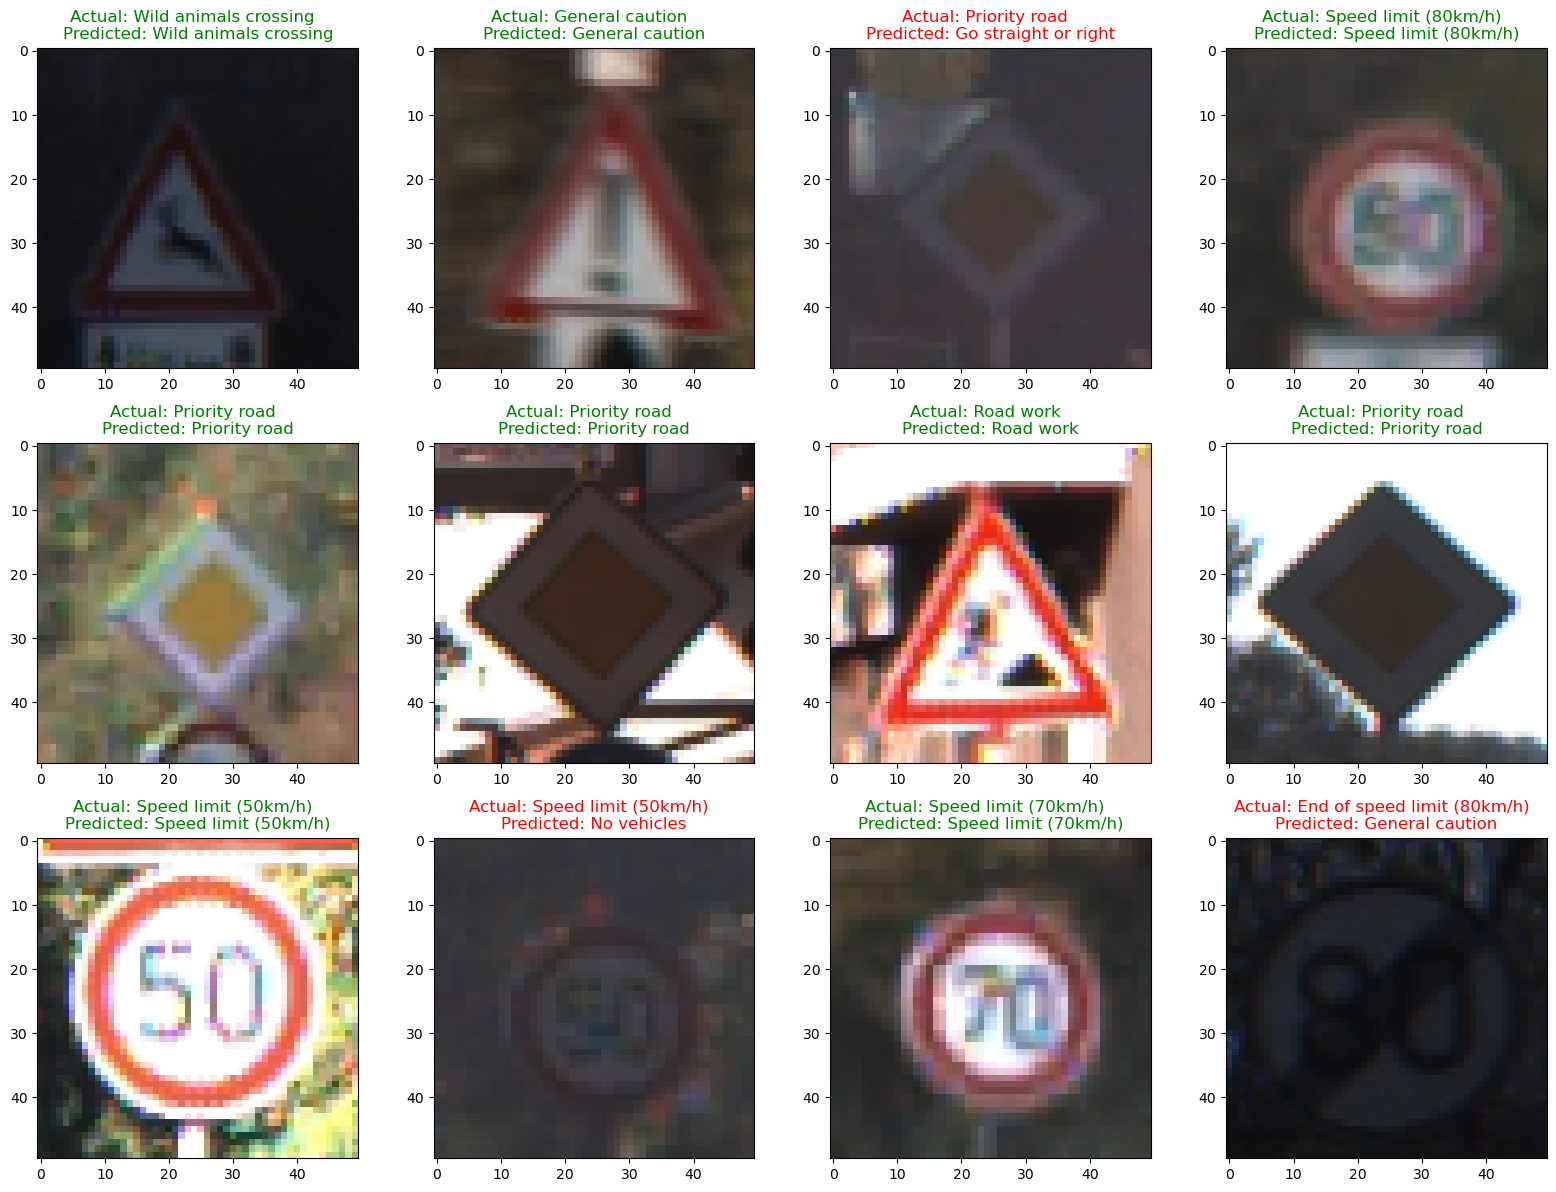

In [ ]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
val_images, val_labels = test_dataset.next()
predicted = vgg_model.predict(val_images)
predicts = map_pred(np.argmax(predicted, axis=-1))
labels = map_pred(np.argmax(val_labels, axis=-1))
for i in range(3):
    for j in range (4):
        idx=rn.randint(0,batch_size-1)
        ax[i,j].imshow(val_images[idx])
        if labels[idx] == predicts[idx]:
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'green')
        else:
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'red')

plt.tight_layout()

### 2. Efficientnet

5/5 [==============================] - 1s 246ms/step


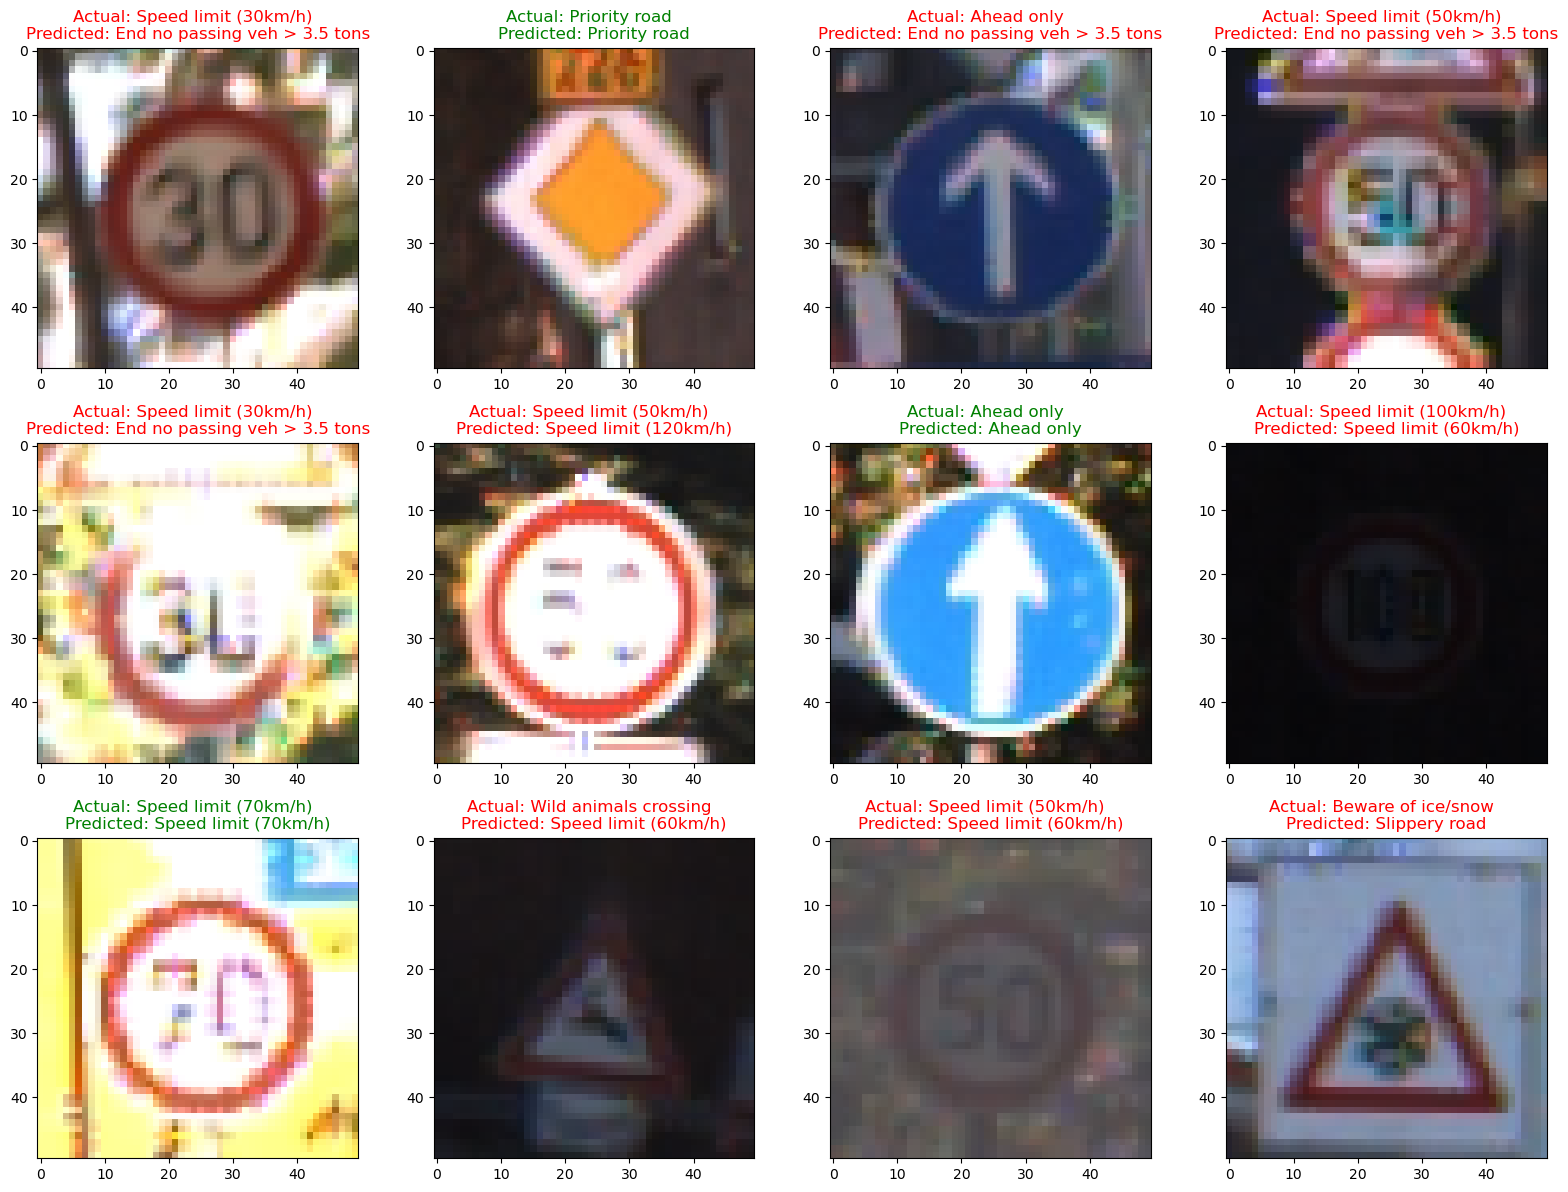

In [ ]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
val_images, val_labels = test_dataset.next()
predicted = Efficientnet_Model.predict(val_images)
predicts = map_pred(np.argmax(predicted, axis=-1))
labels = map_pred(np.argmax(val_labels, axis=-1))
for i in range(3):
    for j in range (4):
        idx=rn.randint(0,batch_size-1)
        ax[i,j].imshow(val_images[idx])
        if labels[idx] == predicts[idx]:
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'green')
        else:
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'red')

plt.tight_layout()

### 3. NASNet

5/5 [==============================] - 1s 189ms/step


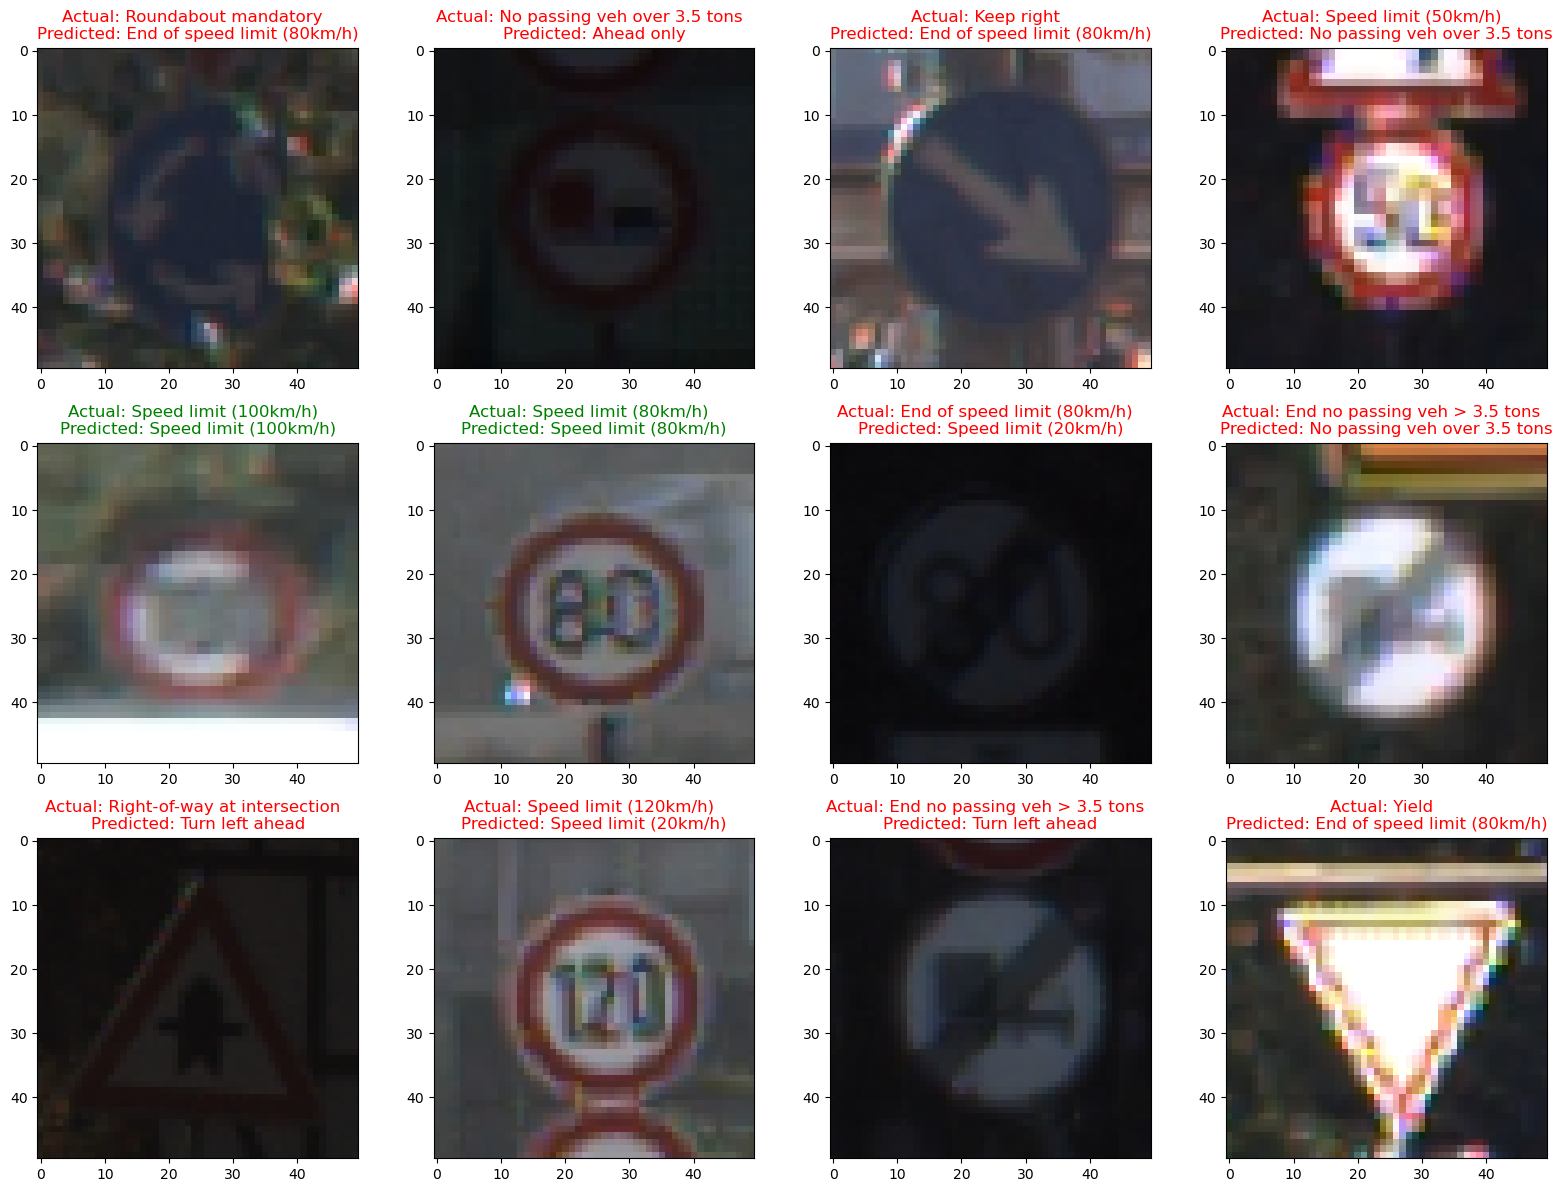

In [ ]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
val_images, val_labels = test_dataset.next()
predicted = Nasnet_Model.predict(val_images)
predicts = map_pred(np.argmax(predicted, axis=-1))
labels = map_pred(np.argmax(val_labels, axis=-1))
for i in range(3):
    for j in range (4):
        idx=rn.randint(0,batch_size-1)
        ax[i,j].imshow(val_images[idx])
        if labels[idx] == predicts[idx]:
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'green')
        else:
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'red')

plt.tight_layout()